### Loads/inspects in the non-diseased Kuppe adata and makes it compatible for combining with other datasets

#### Kuppe et al. 2022 (Kramann Lab)

1. Technology: 10x 3' v3
2. Cell vs. nuclei: Nuclei only
3. Region: LV

Only 4 donors are non-diseased, the rest (n=19) are at different stages of MI.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import scanpy.external as sce

In [2]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

Read in the Kuppe dataset

In [3]:
%%time

# load in the whole dataset
adata = sc.read_h5ad("01_updated_Kuppe_all.h5ad")

# filter only to the donors that are non-diseased
adata = adata[adata.obs.disease == "ND", :]
adata

CPU times: user 655 ms, sys: 4.01 s, total: 4.66 s
Wall time: 4.66 s


View of AnnData object with n_obs × n_vars = 41663 × 28975
    obs: 'cell_type', 'sex', 'donor_id', 'age', 'study', 'technology', 'cell_or_nuclei', 'region', 'disease', 'consistent_cell_type'
    var: 'feature_reference', 'feature_biotype', 'feature_length', 'ensembl_id'
    uns: 'X_approximate_distribution', 'batch_condition', 'cell_type_colors', 'cell_type_original_colors', 'citation', 'consistent_cell_type_colors', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [4]:
# check that these are the raw counts (the sum of all values in the sparse matrix should be an integer value)
adata.X.sum(axis = 1)

matrix([[ 2597.],
        [12988.],
        [ 6358.],
        ...,
        [18578.],
        [ 1790.],
        [ 1339.]], dtype=float32)

In [5]:
adata.obs.head()

,cell_type,sex,donor_id,age,study,technology,cell_or_nuclei,region,disease,consistent_cell_type
index,,,,,,,,,,
AAACCCACAAAGGAGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Fibroblast,male,P1,44,Kuppe 2022,3prime-v3,Nuclei,LV,ND,Fibroblast
AAACCCACAGAGATGC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Cardiomyocyte,male,P1,44,Kuppe 2022,3prime-v3,Nuclei,LV,ND,Cardiomyocyte
AAACCCAGTAACGGTG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Cardiomyocyte,male,P1,44,Kuppe 2022,3prime-v3,Nuclei,LV,ND,Cardiomyocyte
AAACCCAGTCCAGAAG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Fibroblast,male,P1,44,Kuppe 2022,3prime-v3,Nuclei,LV,ND,Fibroblast
AAACCCAGTCGTCGGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,Cardiomyocyte,male,P1,44,Kuppe 2022,3prime-v3,Nuclei,LV,ND,Cardiomyocyte


### Perform Harmony batch integration

Slightly batch effects, so perform harmony integration

In [6]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 223 likely doublets
CPU times: user 15min 31s, sys: 11min 52s, total: 27min 23s
Wall time: 5min 13s


2024-11-23 18:34:33,258 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-23 18:34:36,639 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-23 18:34:36,835 - harmonypy - INFO - Iteration 1 of 10
2024-11-23 18:34:48,863 - harmonypy - INFO - Iteration 2 of 10
2024-11-23 18:35:08,039 - harmonypy - INFO - Iteration 3 of 10
2024-11-23 18:35:22,721 - harmonypy - INFO - Iteration 4 of 10
2024-11-23 18:35:27,311 - harmonypy - INFO - Iteration 5 of 10
2024-11-23 18:35:37,447 - harmonypy - INFO - Iteration 6 of 10
2024-11-23 18:35:48,309 - harmonypy - INFO - Iteration 7 of 10
2024-11-23 18:35:56,623 - harmonypy - INFO - Iteration 8 of 10
2024-11-23 18:36:00,106 - harmonypy - INFO - Iteration 9 of 10
2024-11-23 18:36:03,708 - harmonypy - INFO - Iteration 10 of 10
2024-11-23 18:36:07,467 - harmonypy - INFO - Converged after 10 iterations


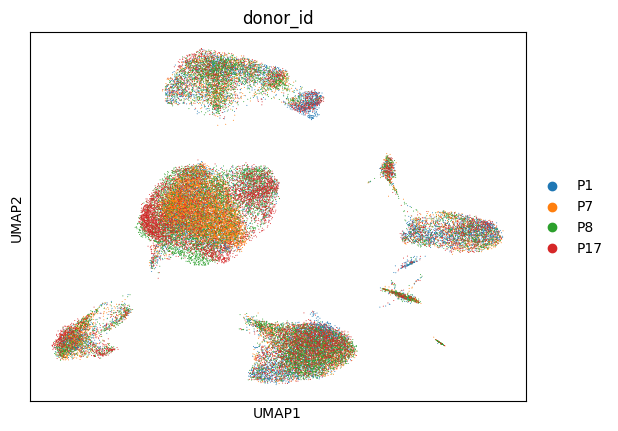

In [7]:
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

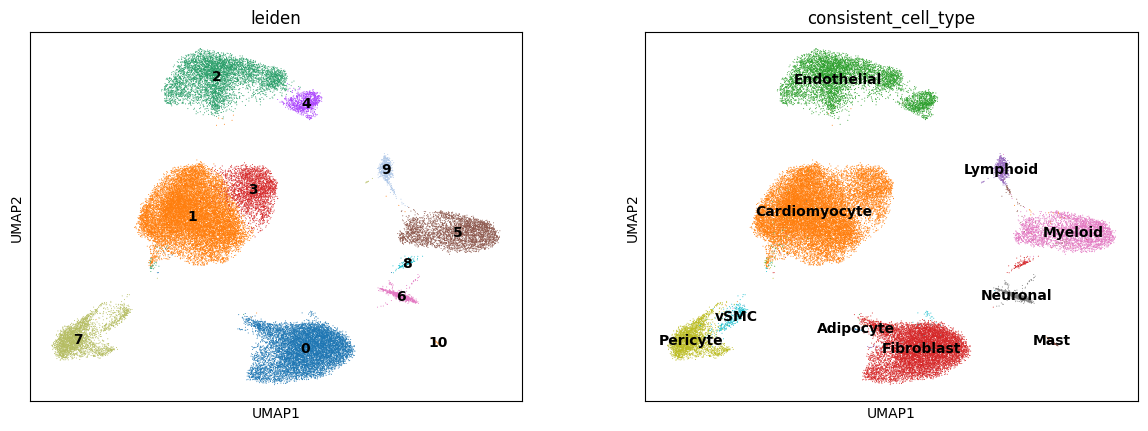

In [8]:
sc.pl.umap(adata, color=["leiden", "consistent_cell_type"], size=2, legend_loc = "on data")

In [9]:
set(adata.obs.consistent_cell_type)

{'Adipocyte',
 'Cardiomyocyte',
 'Endothelial',
 'Fibroblast',
 'Lymphoid',
 'Mast',
 'Myeloid',
 'Neuronal',
 'Pericyte',
 'vSMC'}

In [10]:
adata.write("02_processed_Kuppe_ND.h5ad")